# SVM model for predicting impact position using datasets P1 based on **mfcc** features - Sound

### Model Description

This notebook implements a Support Vector Machine (SVM) model to predict the position of an impact (C, S, V) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting the **mfcc** coefficients using `librosa` library, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys
from sklearn.svm import SVC

### Import Tool Functions

In [3]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
p1_s_samples = "../../../Data/Sound/P1"

### Feature extraction example

213


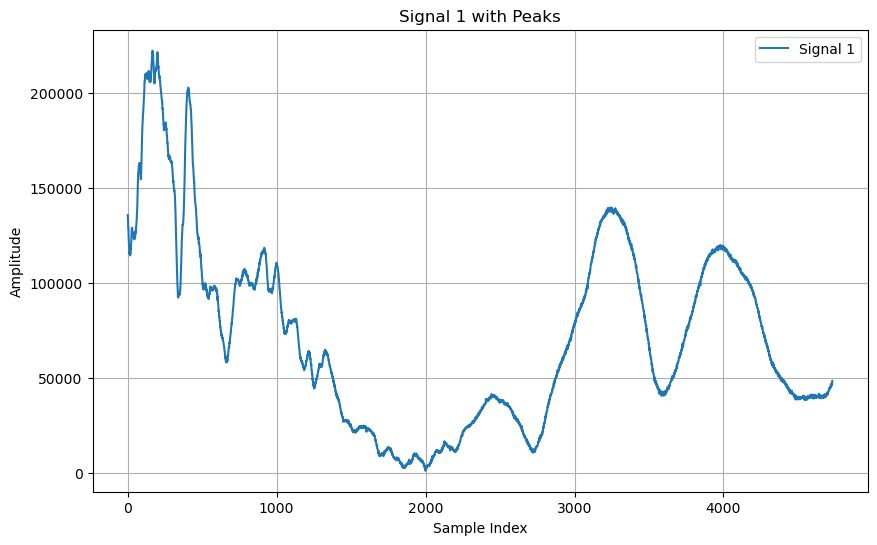

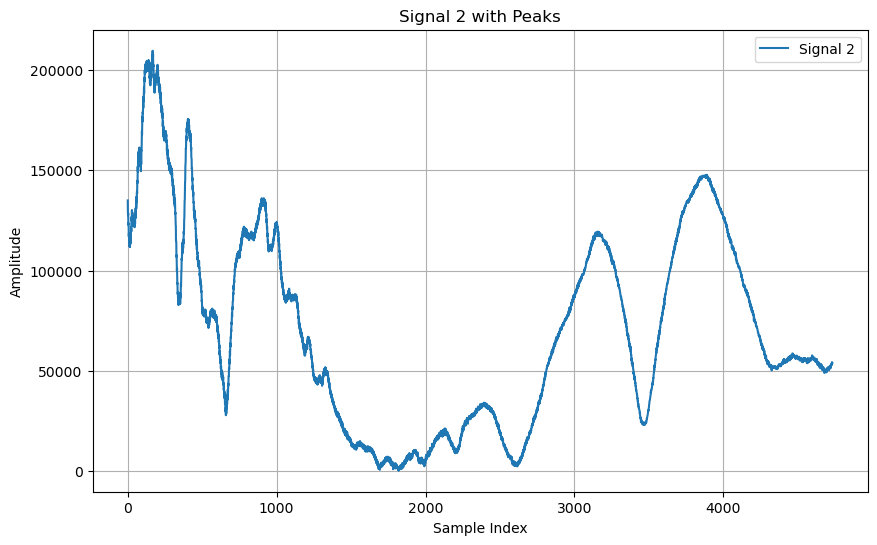

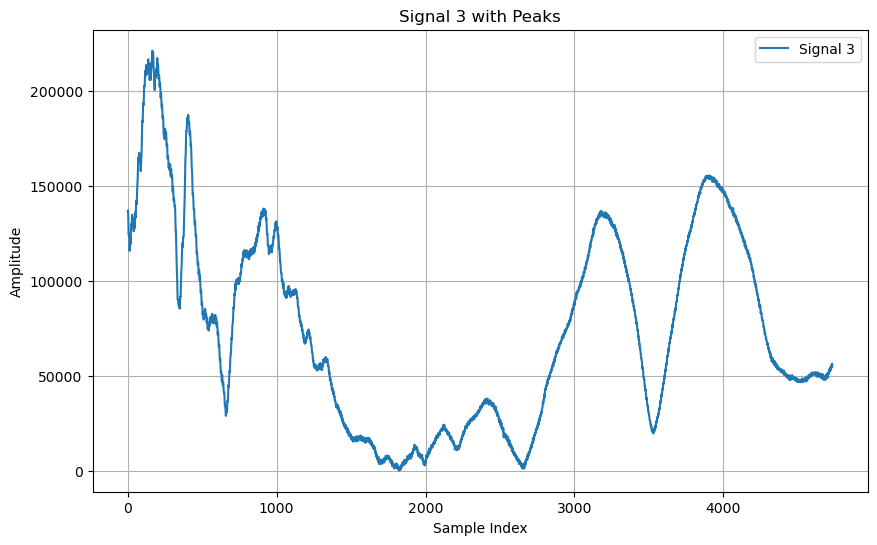

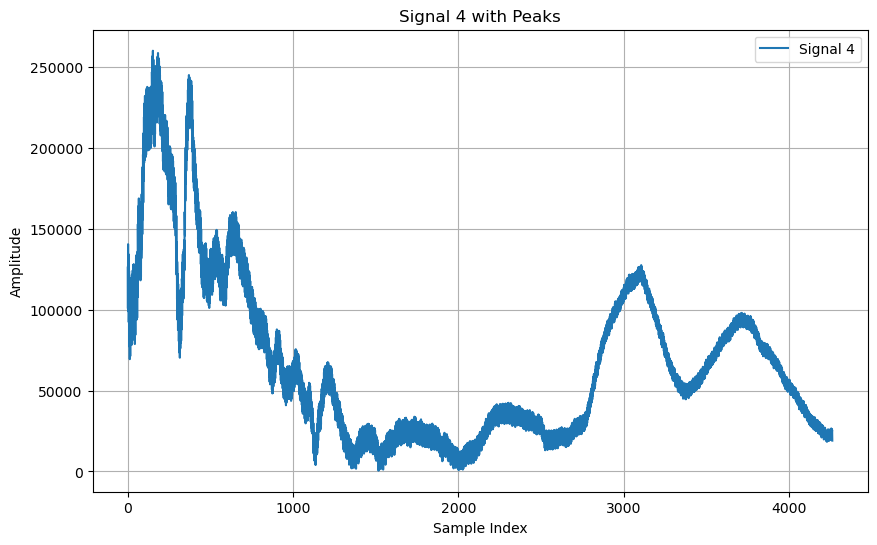

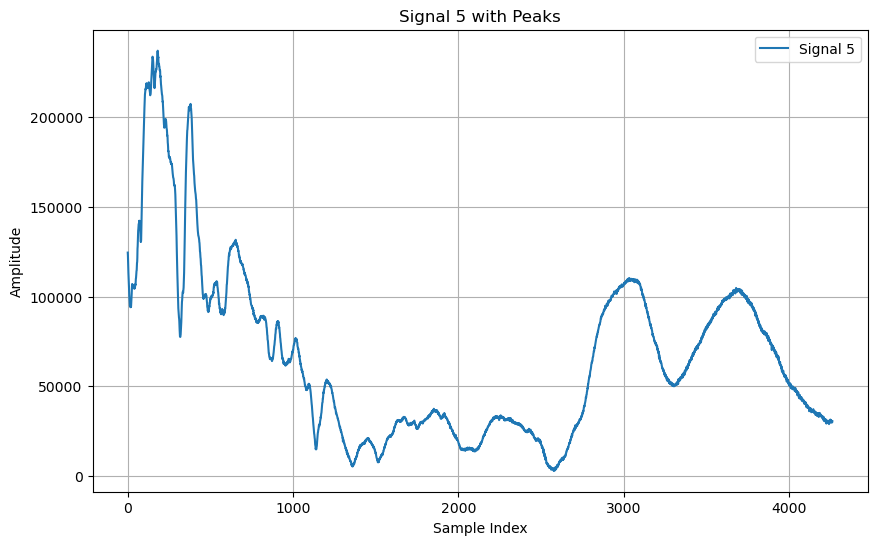

In [4]:
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")
print(len(samplerateVect))
for idx in range(5):  # Loop through the first 5 elements
    spectrum, _ = spectrumFromSignal(testWavFileVect[idx], samplerateVect[idx])
    
    plt.figure(figsize=(10, 6))
    plt.plot(spectrum, label=f"Signal {idx + 1}")
    plt.title(f"Signal {idx + 1} with Peaks")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

## Main

In [5]:
c = 0
results = []
X_mfcc = []
Y_Label=[]

samplerateVect,WavFileVect,filesName = readWavFolder("../../../Data/Sound/P1")

for i, wav in enumerate(WavFileVect):

    if wav.ndim == 1:
        wav = np.stack((wav, wav), axis=-1)
    elif wav.shape[1] == 1:
        wav = np.concatenate((wav, wav), axis=1)

    signal = wav[:, c]
    sr = samplerateVect[i]

    mfcc = librosa.feature.mfcc(y=signal.astype(np.float32), sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # Moyenne sur le temps

    X_mfcc.append(mfcc_mean)

    filename = filesName[i]
    position = 1
    if "C" in filesName[i]:
        position = 1
    elif "S" in filesName[i]:
        position = 2
    elif "V" in filesName[i]:
        position = 3
    Y_Label.append(position)

max_length = max(len(f) for f in X_mfcc)
X_padded = [np.pad(f, (0, max_length - len(f)), constant_values=0) for f in X_mfcc]
X = np.array(X_padded)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred)

    y_train_pred = svc.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)

    results.append({
        'kernel': kernel,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test
    })

results_df = pd.DataFrame(results)

### Save the results

In [6]:

if os.path.exists("S_SVM_Position_P1_mfcc.xlsx"):
    os.remove("S_SVM_Position_P1_mfcc.xlsx")
results_df.to_excel("S_SVM_Position_P1_mfcc.xlsx", index=False)
print("Results have been saved to 'S_SVM_Position_P1_mfcc.xlsx'.")

Results have been saved to 'S_SVM_Position_P1_mfcc.xlsx'.


### Computing the best model

In [8]:
# Get the best configuration
best_config = results_df.loc[results_df['accuracy_test'].idxmax()]
best_accuracy = best_config['accuracy_test']
best_kernel = best_config['kernel']

print(f"Best Hyperparameters:")
print(f"  accuracy test: {best_accuracy}")
print(f"  kernel: {best_kernel}")

# Extract features again for the best n_peak
X_mfcc = []
X_peaksAmplitude = []
Y_Label = []

for i, wav in enumerate(WavFileVect):

    if wav.ndim == 1:
        wav = np.stack((wav, wav), axis=-1)
    elif wav.shape[1] == 1:
        wav = np.concatenate((wav, wav), axis=1)

    signal = wav[:, c]
    sr = samplerateVect[i]

    mfcc = librosa.feature.mfcc(y=signal.astype(np.float32), sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # Moyenne sur le temps

    X_mfcc.append(mfcc_mean)

    filename = filesName[i]
    position = 1
    if "C" in filesName[i]:
        position = 1
    elif "S" in filesName[i]:
        position = 2
    elif "V" in filesName[i]:
        position = 3
    Y_Label.append(position)

max_length = max(len(f) for f in X_mfcc)
X_padded = [np.pad(f, (0, max_length - len(f)), constant_values=0) for f in X_mfcc]
X = np.array(X_padded)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model with the best configuration
svm_best = SVC(kernel=best_kernel)
svm_best.fit(X_train, y_train)

# Predict and visualize
y_pred_best = svm_best.predict(X_test)


Best Hyperparameters:
  accuracy test: 0.5116279069767442
  kernel: linear


### Visualisation

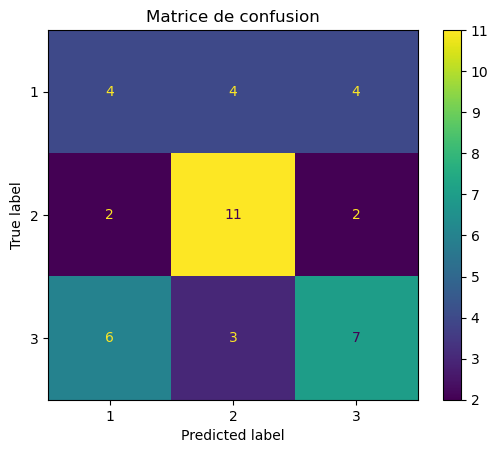

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()